# Transfer Learning (Domain Adversarial Training)


# Readme


<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

## Scenario and Why Domain Adversarial Training

In this project, we have labels with source data and no label with target data. The problem is that the source data and target data are not identical in nature (or, not from the same distribution), but there may have some correlations. 

How could you maximize the resources that you have in hand to predict the target data with the labelled source dataset and unlabelled target dataset?

If you adopt the conventional method that uses Deap Neural Network that trains the source dataset and predict on the target dataset, the result is highly likely to turn out to be a mess (e.g. Anomaly Detection), because the target data are anomaly in the view of source data. 

For example, if we have the following the neural network:

<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

It can accuratelly predict test prictures with the same distribution from source data but cannot predict target data at all. The Feature Extractor does not "learn about" some features from traget data and thus may not give a good prediction.

However, this drawabck can be complemented by the domain adversarial training. 

## Domain Adversarial Training of Nerural Networks (DaNN)

**DaNN complements this drawback by training a feature extractor that maps both the source data and target data to the same distribution after the extraction process**, and then feeds these features (in the same distribution) to classifier. 


<img src="https://i.imgur.com/vrOE5a6.png" width="500px">


It's realized by connecting a Domain Classifier to feature extractor. Feature extractor learns not only how to minimize loss of classifier but also maximize loss of domail classifier, **which means the network cannot tell the difference between source and target**. 

Articl: https://arxiv.org/pdf/1505.07818.pdf

# Data Introduce

Source Data: real pictures of objects
Target Data: handn paintngs of objects

Datasets download URL(https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL)


In [ ]:
8# Download dataset
!gdown --id '12-07DSquGdzN3JBHBChN4nMo3i8BqTiL' --output real_or_drawing.zip
# Unzip the files
!unzip real_or_drawing.zip

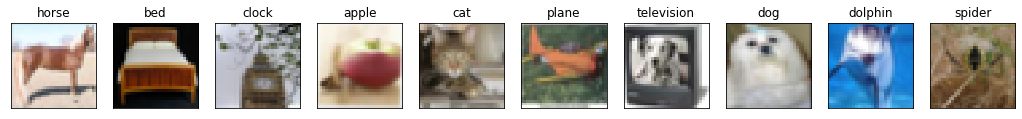

In [2]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, zoom using nearest。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # emit axis
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

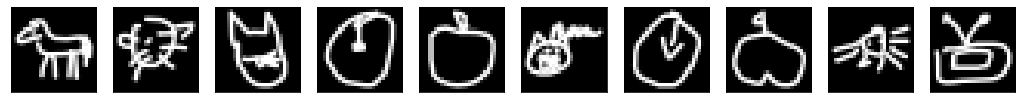

In [3]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

After observing the source and target data, we find that in the hand-paintings (target data), it depicts (mostly) the edge of an object, so we manipulate the source data to rettain the edge. Then the source data looks more like the target data. 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


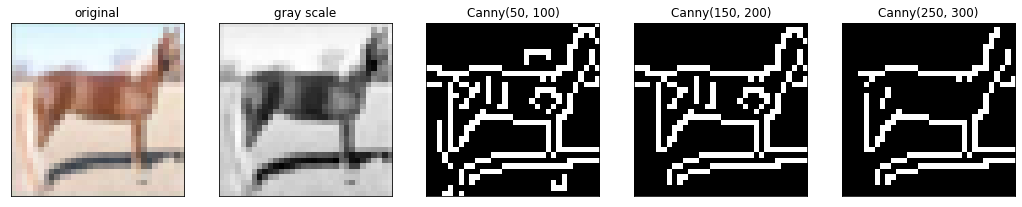

In [4]:
import cv2
import matplotlib.pyplot as plt

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process

Use torchvision.ImageFolder to package the original data so that it can be fed to DataLoader.



In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

source_transform = transforms.Compose([
    # transform the picture from RGB to grayscale
    transforms.Grayscale(),
    # transform Image to np.array and feed to cv2.Canny (cv2  accepts np.array only)
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # transform  np.array back to skimage.Image
    transforms.ToPILImage(),
    # Horizontal Rotation (Augmentation)
    transforms.RandomHorizontalFlip(),
    # 15-degree rotate
    transforms.RandomRotation(15, fill=(0,)),
    # to tensor
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    # transform the picture from RGB to grayscale
    transforms.Grayscale(),
    # source data size: 32x32; transform target data from 28x28 to 32x32
    transforms.Resize((32, 32)),
    # Horizontal Rotation (Augmentation)
    transforms.RandomHorizontalFlip(),
    # 15-degree rotate
    transforms.RandomRotation(15, fill=(0,)),
    # to tensor
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: VGG-like NN

Label Predictor / Domain Classifier: MLP


In [6]:
# VGG-like NN
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

# Multilayer Perception
class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Optimizer: Adam

In [7]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Start Training

In the paper: add a Gradient Reversal Layer and train Feature Extractor / Label Predictor / Domain Classifier all together

In our project: to achieve the same effect, we **Alternately**
 train Domain Classfier & Feature Extractor (F->C->D->F->C)

In [8]:
def train_epoch(source_dataloader, target_dataloader, lamb):

    '''
      Args:
        source_dataloader: dataloader of source data
        target_dataloader: dataloader of target data
        lamb: adjust the loss of adversarial
    '''

    # D loss: loss of Domain Classifier 
    # F loss: loss of Feature Extrator & Label Predictor

    # total_hit: the number of correct predictions
    # total_num: the total number of predictions

    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # 我們把source data和target data混在一起，否則batch_norm可能會算錯 (兩邊的data的mean/var不太一樣)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()

        # mark source data as labe1 1
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train Domain Classifier
        feature = feature_extractor(mixed_data)

        # detach features beacause we do not train the Feature Extractor 
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train Feature Extractor and Label Predictor
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)

        # loss: originial class CE - lamb * domain BCE (just like G loss in GAN Discrimination) 
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

# epochs = 200
for epoch in range(200):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=0.1)

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))


epoch   0: train D loss: 0.6575, train F loss: 1.9653, acc 0.2530
epoch   1: train D loss: 0.5977, train F loss: 1.6127, acc 0.3946
epoch   2: train D loss: 0.5560, train F loss: 1.4433, acc 0.4696
epoch   3: train D loss: 0.5269, train F loss: 1.3834, acc 0.4970
epoch   4: train D loss: 0.5486, train F loss: 1.3070, acc 0.5220
epoch   5: train D loss: 0.5375, train F loss: 1.2644, acc 0.5418
epoch   6: train D loss: 0.5506, train F loss: 1.2153, acc 0.5542
epoch   7: train D loss: 0.5248, train F loss: 1.1797, acc 0.5726
epoch   8: train D loss: 0.5452, train F loss: 1.1417, acc 0.5846
epoch   9: train D loss: 0.5431, train F loss: 1.1103, acc 0.5978
epoch  10: train D loss: 0.5528, train F loss: 1.0681, acc 0.6112
epoch  11: train D loss: 0.5326, train F loss: 1.0403, acc 0.6212
epoch  12: train D loss: 0.5459, train F loss: 1.0223, acc 0.6240
epoch  13: train D loss: 0.5378, train F loss: 0.9886, acc 0.6354
epoch  14: train D loss: 0.5335, train F loss: 0.9294, acc 0.6548
epoch  15:

# Inference

save result in csv

In [9]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)


In [10]:
from google.colab import files
files.download("DaNN_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>